----
# Bayesian Data Analysis - Premier League Project
----

## Table of Contents
<ul>
    <li>Imports</li>
    <li>Background</li>
    <li>Data</li>
    <li>Model 1: Hierarchical model</li>
    <li>Sources</li>
</ul>

## Imports

In [5]:
import numpy as np
import arviz as az
import stan
import nest_asyncio
import warnings
import matplotlib.pyplot as plt

## Background

<b>Bayesian methods in sports</b><br>
The usage of Bayesian methods in sports analytics has been increasing due to the increasing amount of statistics gathered from sports and also the multiple advantages that Bayesian methods have (Santos-Fernandez et al., 2019). Bayesian approach allows for example to provide probabilistic estimates, add new information to models and make predictions that take the uncertainty into consideration. 

<b>Premier League</b><br>
As I am a big football fan, I have decided to do the project about the English Premier league. In the summer of 2021 a big English football club, Manchester United, decided to re-sign Ronaldo from Juventus with a transfer costing about £12.85 million. On top of this, Ronaldo's yearly salary is estimated to be about $125 (Settimi, 2021), at least in this project.

Despite of being a Tottenham Hotspur fan, in this project I am using Bayesian methods to do decision analysis for Manchester United (obviously not <I>really</I> :D). 

<b>This project</b><br>
In this project we are going to assess whether Manchester United should re-sign Ronaldo in the summer of 2021. As nowadays football is mostly about money and business, we are going to base our decision only on money. To model the amount of money Ronaldo provides for ManU, we are going to use the amount of goals Ronaldo will score in a season. However, as Ronaldo has not played in the EPL for ages and Serie A/LaLiga goals are arguably not comparable with EPL goals, we cannot use for example the average of Ronaldo's previous goal scoring numbers as a point estimate for the goals in EPL or model with Bayesian methods straight from the data. Therefore, we are going to model Ronaldo's expected goal scoring with two bayesian models that use data also from EPL: Hierarchical model and Pooled model. The models are explained comprehensively in the Model-part of the this notebook.

<b>IMPORTANT</b><br>
This project is just for training with Bayesian Data Analysis and the model provided in the project is not intended to work in the real world.

## Data

As Ronaldo has played 11 seasons (from season 2009-2010 until 2020-2021) outside the EPL, it is not possible to obtain a huge amount of data of the goals scored. But the beauty of Bayesian methods is that we can work with small amount of data and still get a distribution of our predictions.<br>

In this project for simplicity we will only use goals that have been scored in EPL, LaLiga or Serie A and therefore we ignore goals for example scored in Champions League. For the Manchester United forward goals we are going to use each season the top 3 goal scoring forward's goals as no player has played in Manchester United the whole time that Ronaldo has played. Therefore we have three columns on our ManU data, each representing a unidentified player. This can be rationalized by the fact that we are not interested in these players from the ManU population and their meaning in this model is to add the ManU way of playing to the model. The first column in the file manu.txt corresponds to the top scorer (forward or attacking midfielder) of the season and the two others are for the 2nd and 3rd best each season. Therefore we can assume that we have three unidentified players as the columns.

Ronaldo's goal scoring data is from ESPN.com and it is manually collected as there is no universal free database for football statistics. The ManU goals are from Premier League's official website, premierleague.com, and they are also manually collected. We will use data starting from season 2009-2010 until season 2020-2021, as these are the seasons Ronaldo played in LaLiga and Serie A.

In [2]:
# DATA FOR RONALDO
data = []
with open("./data/cr7.txt") as file:
    for line in file:
        values = line.rstrip()
        data.append(values)
data_cr7 = np.array([int(value) for value in data])

In [3]:
# DATA FOR MANU FORWARDS
data = []
with open("./data/manu.txt") as file:
    for line in file:
        values = line.rstrip().split(",")
        data.append(values)
data_manu = np.array([[int(value) for value in values] for values in data])

We can also plot the data before we start to predict, so that we have some idea on what we are talking about.

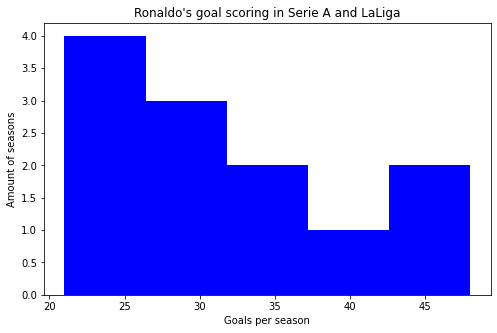

In [43]:
plt.figure(figsize=(8, 5))
plt.hist(x=data_cr7, bins=5, color="blue")
plt.title("Ronaldo's goal scoring in Serie A and LaLiga")
plt.xlabel("Goals per season")
plt.ylabel("Amount of seasons");

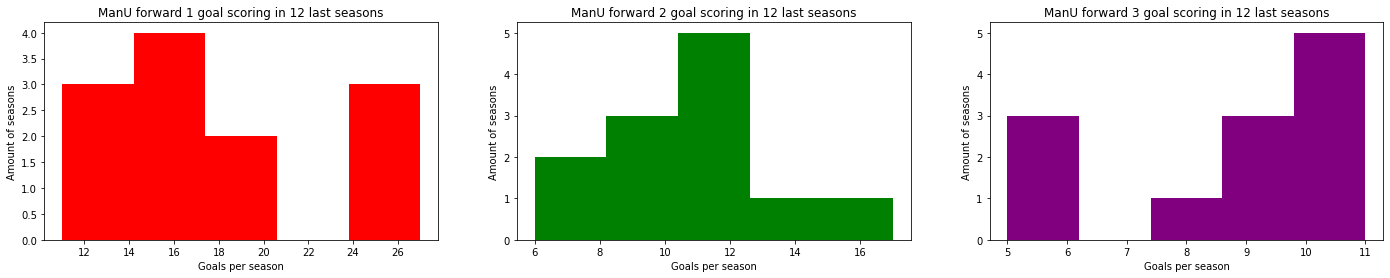

In [44]:
fig, ax = plt.subplots(1,3)
fig.set_size_inches(24, 4)

ax[0].hist(x=data_manu[:, 0], bins=5, color="red")
ax[0].set_title("ManU forward 1 goal scoring in 12 last seasons")
ax[0].set_xlabel("Goals per season")
ax[0].set_ylabel("Amount of seasons")

ax[1].hist(x=data_manu[:, 1], bins=5, color="green")
ax[1].set_title("ManU forward 2 goal scoring in 12 last seasons")
ax[1].set_xlabel("Goals per season")
ax[1].set_ylabel("Amount of seasons")

ax[2].hist(x=data_manu[:, 2], bins=5, color="purple")
ax[2].set_title("ManU forward 3 goal scoring in 12 last seasons")
ax[2].set_xlabel("Goals per season")
ax[2].set_ylabel("Amount of seasons");

## Model 1 - Hierarchical Model

### Description

In the first model we are going to model Ronaldo's expected goal amount in a season using a hierarchical model, where we are going to use also the goal scoring of other Manchester United forwards in previous seasons. As each team in EPL have their own style of playing, we can argue that there also is a specific amount of goals that usually occur from that style of playing. Therefore, we could assume that Ronaldo's goal amount in ManU shirt is related to the goal amount of other ManU forwards and therefore we could use a hierarchical model, where we take advantage of the data we have from the other forwards.<br>

Now, we could take the easy way and make our predictions just by using the ManU forward population (scored goals in each season), give some weakly informative hyperpriors and sample hyperparameters for the priors for each player, create a fitting likelihood function and sample a predictive distribution for a new player coming in the ManU team (Ronaldo). However, the prediction would not be that accurate as Ronaldo is not some random player coming to the club, but one of the best players in the world. How can we add this knwoledge of Ronaldo's skills to our model, while still keeping the information from the ManU forward population distribution? One possible way, which is used in this model, is to obtain the prior for Ronaldo's goal scoring from the ManU population distribution and add Ronaldo's skills to the model through data from his past goal scoring in LaLiga and Serie A.<br>

Therefore, as the hierarchical model we get:<br>

As hyperpriors we are going to use for sigma


### Stan model

As the resulting posterior distribution is hard to compute, we are going to sample from it using Markov Chain Monte Carlo methods. To do this, we use a software called Stan and its Python library PyStan3. Stan uses dynamic Hamiltonian Monte Carlo (by default No-U-Turn Sampler, NUTS) as the MCMC-method to sample from the posterior distribution as it needs fewer Markov Chain samples to converge than for example Gibbs sampling.

Stan implementation of the model:

### Implementation

In [ ]:
# STAN MODEL
nest_asyncio.apply()
inputs = {'N': data.shape[0], 'J': data.shape[1], 'y': data}
model = stan.build(program_code=hier_stan, data=inputs);
hier_fit = model.sample();
hier_df = hier_fit.to_frame()

### Convergence diagnostics

### Posterior predictive checking

### Sensitivity analysis

### Decison analysis

### Problems in our model

<b>Exchangeability</b><br>
First problem of our model is that the groups in the ManU forward data are not clearly exchangeable as we know that they are selected so that the first group is the best forward, second group the second best and the third one the third best. However, as we know that they all are samples from the same population distribution (ManU forward goal scoring distribution), I claim that this knowledge of their order does not matter in this context and as we model a prior distribution from this hierarchical model for the real posterior distribution, we are using a two level hierarchical model that models also the variation between the groups and therefore only partial exchangeablity is needed. Also, we do not have knowledge that the first forward is <b>better</b> at scoring, we just have data where he has scored more goals. Therefore, I claim that we can assume that all the groups are from the same distribution and the data just happens to be ordered.

## Model 2 - Pooled Model

## Model comparison

## Sources

Santos-Fernandez, E. & Wu, P. & Mengerson, K. L. (2019). Bayesian statistics meets sports: a comprehensive review. Journal of Quantitative Analysis in Sports. Vol. 15(4). S. 289-312.

Settimi, C. (2021). The World’s Highest-Paid Soccer Players 2021: Manchester United’s Cristiano Ronaldo Reclaims Top Spot From PSG’s Lionel Messi. Forbes. 